## acquire

Zillow data:
- 2017 data
- Latest transaction per property id only.
- The logerror from that latest transaction.
- All fields related to the properties.
- Gather descriptions from the lookup tables.
- Only properties with latitude and longitude.
- Only single family homes.

In [517]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, QuantileTransformer, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

import acquire
import summarize
import prepare

In [220]:
df = acquire.get_zillow_data()

Only single family

In [221]:
df = df[df.propertylandusedesc == 'Single Family Residential']

## prepare 

### Missing Values

- remove columns with > 99% missing and rows  > 40% missing
- aggregate pool information: use all pool and spa columns to compute a single boolean attribute of `has_pool`
- fill with 0: taxdelinquencyflag, fireplacecnt, garagecarcnt and convert them to boolean
- After doing all that, then remove all columns with > 5% missing, and following that, rows with > 99% missing

In [222]:
# remove columns with > 99% missing and rows  > 40% missing
df = prepare.handle_missing_values(df, prop_required_column = .01, prop_required_row = .40)

# aggregate pool information: use all pool and spa columns to compute a single attribute of pool_spa
# gather pool columns
pool_cols = ['hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7']
# fill all missing values with 0
pool = df[pool_cols].fillna(0)
# where there is a value in one or more of the pool attributes, assign a 1 to a new col named 'pool'
pool.loc[pool.sum(axis=1)>0, 'has_pool'] = 1
# append the new column to our original dataframe and remove the original pool columns 
df = df.join(pool[['has_pool']])

# fill with 0
df.loc[df.taxdelinquencyflag == 'Y', 'is_taxdelinquent'] = 1
df.loc[df.fireplacecnt > 0, 'has_fireplace'] = 1
df.loc[df.garagecarcnt > 0, 'has_garage'] = 1
fill_with_0 = ['has_garage', 'has_fireplace', 'has_pool', 'is_taxdelinquent']
df[fill_with_0] = df[fill_with_0].fillna(0)

# remove columns where > 5% missing and rows where > 99% missing
df = prepare.handle_missing_values(df, prop_required_column = .95, prop_required_row = .99)

### Variable Changes

Are there any instances where taxvaluedollarcnt is not equal to the sum of the land tax value and the structure tax value? (landtaxvaluedollarcnt + structuretaxvaluedollarcnt). 

In [223]:
np.where((df.taxvaluedollarcnt - (df.landtaxvaluedollarcnt + df.structuretaxvaluedollarcnt)) != 0)
# add taxvaluedollarcnt to list to drop

(array([], dtype=int64),)

No. I will attempt to reduce the dependency between variables and extracting the most unique information from each. 

- `land_dollar_per_sqft`: a land dollar per sqft (landtaxvaluedollarcnt/lotsizesquarefeet)
- `structure_dollar_per_sqft`: structuretaxvaluedollarcnt/calculatedfinishedsquarefeet
- `tax_rate`: taxvaluedollarcnt/taxamount
- compute `living_area_sqft` by subtracting estimated square feet from bedrooms (121: 11x11) and bathrooms (36: 6x6)
- compute `bedbath_index` where multiple bedrooms by a weight of 2, full baths by weight of 1, half/three-quarter baths by weight of .5, then sum them all together.  


In [224]:
df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet
df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
df['living_area_sqft'] = df.calculatedfinishedsquarefeet - (df.bedroomcnt*121 + df.bathroomcnt*36)
df['tax_rate'] = df.taxvaluedollarcnt/df.taxamount
df['bedbath_index'] = df.bedroomcnt*2 + df.fullbathcnt + .5*(df.bathroomcnt-df.fullbathcnt)

- turn yearbuilt into age (from present)
- reduce regionidcity into the top 5 cities and the others assign to a catch-all id.
- take the first 3 digits of zip to reduce the variance in zipcode 
- Look at variables that don't actually represent numeric values to think about encoding. (fips, regionidcity, regionidzip, regionidcounty)

In [225]:
df['age'] = 2017 - df.yearbuilt

In [226]:
df.loc[:,'latitude'] = df.loc[:,'latitude']/1e6
df.loc[:,'longitude'] = df.loc[:,'longitude']/1e6

City ID and County: Is there any cross-over or is city purely a subset of county? 

Count the number of counties each city is located in:

In [227]:
ct = pd.DataFrame(pd.crosstab(df.regionidcity, df.regionidcounty))
s = ct.astype(bool).sum(axis=1)
s = s.where(s>1).dropna()
pd.crosstab(df[df.regionidcity.isin(list(s.index))].regionidcity, df[df.regionidcity.isin(list(s.index))].regionidcounty)

regionidcounty  1286.0  2061.0  3101.0
regionidcity                          
5465.0               2       0     210
10608.0            375       0       1
12447.0              0       1   11237
12520.0              0       3     153
15237.0             71       0       3
18874.0            252       0       5
41673.0              0     124       1
44833.0            247       0       1

Taking a look at these, I can see that when there are multiple counties, there is clearly a dominant county and only a handful of properties in the other. I will 'fix' the anomalies to be in what is likely the correct county. I'll test it here, but will need to implement above before we do all the prepping. 

In [228]:
df.loc[df.regionidcity.isin([5465.0,12447.0,12520.0]), 'regionidcounty'] = 3101.0
df.loc[df.regionidcity.isin([10608.0,15237.0,18874.0,44833.0]), 'regionidcounty'] = 1286.0
df.loc[df.regionidcity==41673.0, 'regionidcounty'] = 2061.0
df.regionidcounty.value_counts()

3101.0    32647
1286.0    13500
2061.0     4303
Name: regionidcounty, dtype: int64

- Looking at the counts for each county, it seems reasonable to not split county 2061 geographically much more than that.  
- County 1286 can probably be split more effectively: city 16764 and all others 
- County 3101 can definitedly be split more effectively: city 12447, 5534, 46298, 40227, and all others

However, I'm going to wait to do this. I will first run some statistical tests to see if there are cities and zips that have significantly different logerror from the rest of the properties. 

In [229]:
# df.loc[(df['regionidcity']==12447) | (df['regionidcity']==5534) | (df['regionidcity']==40227) | (df['regionidcity']==46298) | (df['regionidcity']==16764), 'cityid'] = df['regionidcity']
# df.cityid.fillna(0, inplace=True)

In [230]:
# have to do float first because of an issue with 0.0, then int, then string to ensure no decimals in the string.  
# df['cityid'] = df.cityid.astype(float).astype(int).astype(str)
df['regionidcity'] = df.regionidcity.astype(float).astype(int).astype(str)
df['regionidzip'] = df.regionidzip.astype(float).astype(int).astype(str)
df['regionidcounty'] = df.regionidcounty.astype(float).astype(int).astype(str)

In [231]:
# df['loc_id'] = df.regionidcounty + '_' + df.cityid

In [232]:
# clean up remaining columns
df_prepped = df.drop(columns=(['id','parcelid','assessmentyear','propertycountylandusecode',
                               'propertylandusedesc','transactiondate', 'propertylandusetypeid',
                               'finishedsquarefeet12', 'taxvaluedollarcnt', 'fips',
                               'yearbuilt', 'rawcensustractandblock', 'censustractandblock', 'roomcnt', 
                               'calculatedbathnbr','taxamount','calculatedfinishedsquarefeet',
                               'landtaxvaluedollarcnt','structuretaxvaluedollarcnt',
                               'bedroomcnt','bathroomcnt','fullbathcnt'
                              ]))

In [233]:
df_prepped.shape

(50450, 17)

### Split Data

In [421]:
train, test = train_test_split(df_prepped, test_size=.30)

### Scaling

#### Create Uniform Scaler
when we the space between doesn't matter as much as order does, a uniform scaler is a good choice. 

In [422]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

#### Create MinMax Scaler
When we want to preserve distance but want to be within bounds, a min-max scaler is a good choice. 

In [423]:
def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

We will scale square feet, dollar per square foot, tax rate, beds & baths using a uniform scaler as that will help minimize the impact extreme outliers will have. 

For latitude, longitude and age, we want to preserve the distance between. We want 1876 to be futher away from the next oldest house of 1900 than 1900 is from the next oldest house of 1901. For this reason, we will use a min-max scaler. 

In [424]:
column_list1 = ['lotsizesquarefeet','structure_dollar_per_sqft','land_dollar_per_sqft','living_area_sqft','tax_rate','bedbath_index']
train, test, scaler_uniform = scale_uniform(train, test, column_list1)

column_list2 = ['latitude','longitude','age']
train, test, scaler_minmax = scale_minmax(train, test, column_list2)

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [425]:
# train_prepped.describe().T
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35315 entries, 35603 to 50036
Data columns (total 17 columns):
regionidcity                 35315 non-null object
regionidcounty               35315 non-null object
regionidzip                  35315 non-null object
logerror                     35315 non-null float64
has_pool                     35315 non-null float64
is_taxdelinquent             35315 non-null float64
has_fireplace                35315 non-null float64
has_garage                   35315 non-null float64
lotsizesquarefeet            35315 non-null float64
structure_dollar_per_sqft    35315 non-null float64
land_dollar_per_sqft         35315 non-null float64
living_area_sqft             35315 non-null float64
tax_rate                     35315 non-null float64
bedbath_index                35315 non-null float64
latitude                     35315 non-null float64
longitude                    35315 non-null float64
age                          35315 non-null float64
dtypes

## Cluster

### K-Means

#### Elbow Method to determine best 'K'

1. Let's first cluster by geolocation of latitude and longitude along with dollar per square foot (land and structure) and tax rate.

2. Then we will cluster by lot size, living area, beds and baths, and age. 

##### Clustering 1: location, dollar/sqft, tax rate

In [426]:
cluster1_cols = ['latitude','longitude','land_dollar_per_sqft','structure_dollar_per_sqft']

Compute and plot the sum squared distances of each sample to closest cluster center at each k-value.  

In [427]:
def select_k(cluster_df, ks):
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
        kmeans.fit(cluster_df)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    # print(pd.DataFrame(dict(k=ks, sse=sse)))

    p = plt.plot(ks, sse, 'bx-')
    p = plt.xlabel('k')
    p = plt.ylabel('SSE')
    p = plt.title('The Elbow Method to find the optimal k')

    compare_df = pd.DataFrame(dict(k=ks, sse=sse)).assign(change_in_sse=lambda df: df.sse.diff())
    return compare_df, p

(     k          sse  change_in_sse
 0    1  8321.754878            NaN
 1    2  5220.170774   -3101.584104
 2    3  4032.259668   -1187.911106
 3    4  3246.365182    -785.894486
 4    5  2811.540444    -434.824737
 5    6  2521.055903    -290.484542
 6    7  2248.973274    -272.082629
 7    8  1991.232837    -257.740436
 8    9  1854.071798    -137.161039
 9   10  1701.622946    -152.448852
 10  11  1619.810986     -81.811961
 11  12  1535.075077     -84.735909,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

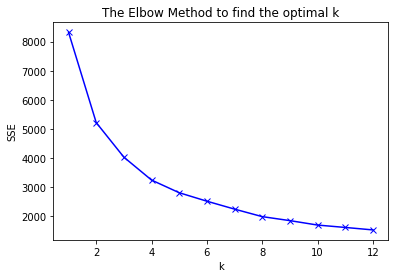

In [243]:
select_k(cluster_df = train[cluster1_cols], ks = range(1,13))

I would say 6 or 8 is hwere the bottom of the elbow sits.  
Let's compare k=6 vs. k=8. 

In [244]:
def compare_clusters(cluster_df, x_column, y_column, z_column, k1, k2):
    estimators = [(str(k1)+' Clusters', KMeans(n_clusters=k1, n_init=1, max_iter=100, random_state=123)),
                  (str(k2)+' Clusters', KMeans(n_clusters=k2, n_init=1, max_iter=100, random_state=123))]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
    
    for ax, (title, kmeans) in zip(axs, estimators):
        # fit the kmeans object
        kmeans.fit(cluster_df)
        
        labels = kmeans.labels_
        
        ax.scatter(cluster_df[x_column], 
                   cluster_df[y_column],
                   cluster_df[z_column],
                   c=labels.astype(np.float), edgecolor='k')
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.set(xlabel=x_column, ylabel=y_column, zlabel=z_column)
        ax.set(title=title)
    
    plt.show()

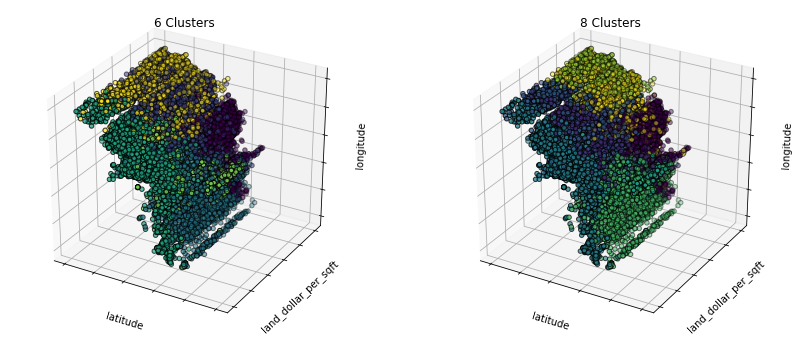

In [245]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='latitude', y_column='land_dollar_per_sqft', z_column='longitude',
                k1=6, k2=8)

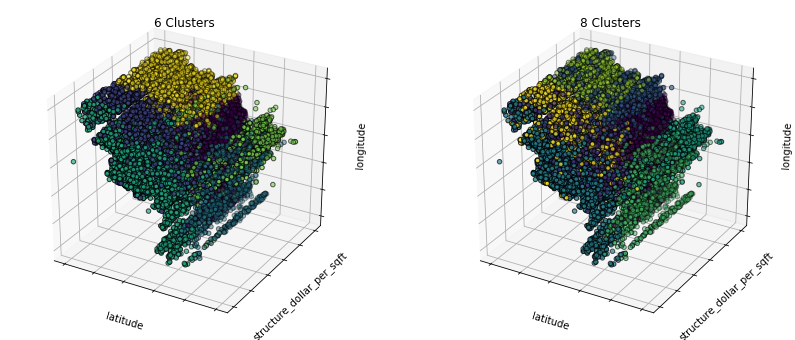

In [246]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='latitude', y_column='structure_dollar_per_sqft', z_column='longitude',
                k1=6, k2=8)

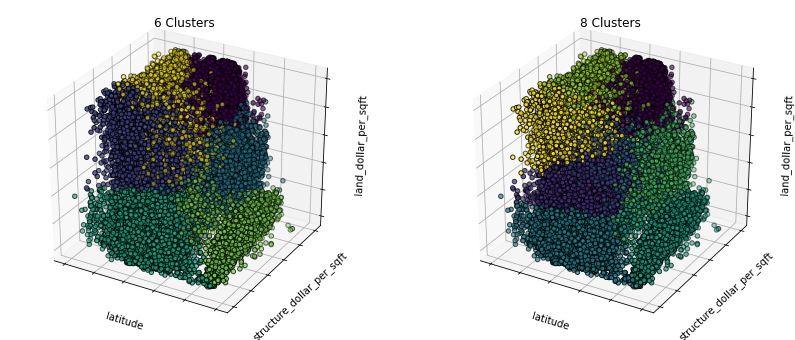

In [247]:
compare_clusters(cluster_df=train[cluster1_cols],
                x_column='latitude', y_column='structure_dollar_per_sqft', z_column='land_dollar_per_sqft',
                k1=6, k2=8)

As latitude moves east (left on the chart), we can see the land dollar per sqft and structure dollar per sqft increases, indicated by the slope upward as you move back and to the left. (low latitude, high structure dollar per sqft, high land dollar per sqft. 

I'm going to go with 8.

In [428]:
def create_k_clusters(train, test, cluster_feature_id, cluster_cols, k):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=100, random_state=123)
    kmeans.fit(train[cluster_cols])
    cluster_feature = 'cluster'+str(cluster_feature_id)+'_id'
    train[cluster_feature] = kmeans.predict(train[cluster_cols])
    test[cluster_feature] = kmeans.predict(test[cluster_cols])
    return train, test, kmeans

In [429]:
train, test, kmeans1 = create_k_clusters(train, test, cluster_feature_id = 1, cluster_cols = cluster1_cols, k=8)

In [430]:
train.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)
test.rename(index=str, columns={'cluster1_id': 'cluster_loc'}, inplace=True)

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


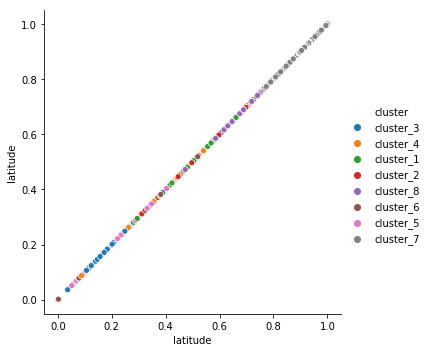

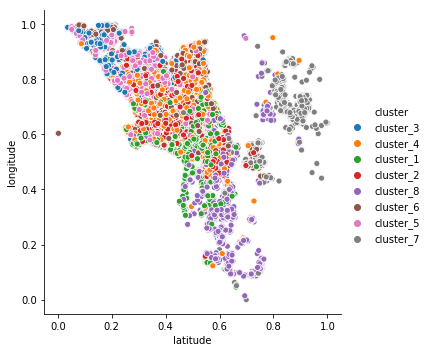

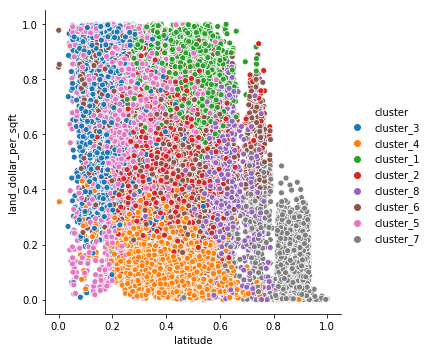

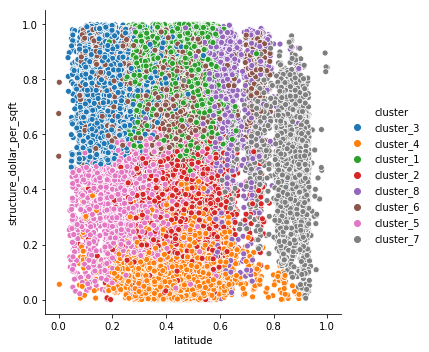

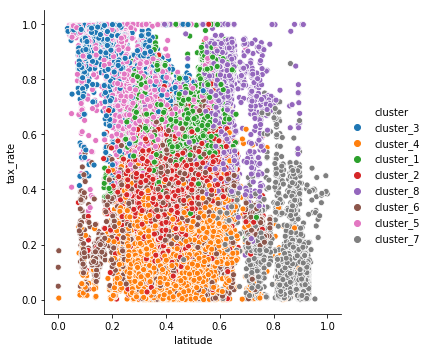

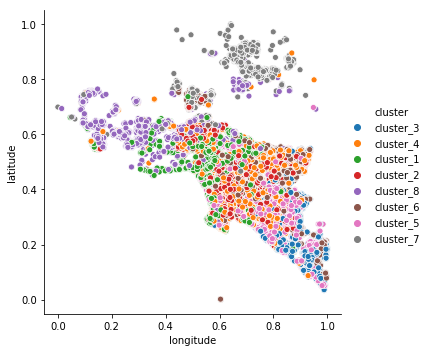

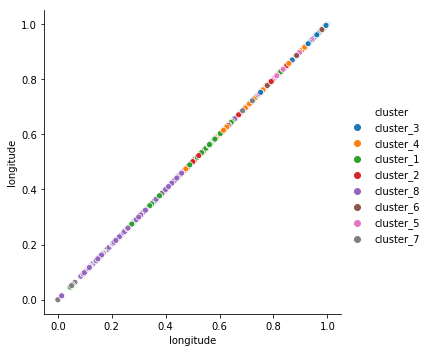

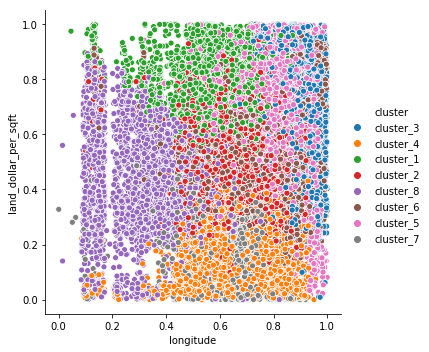

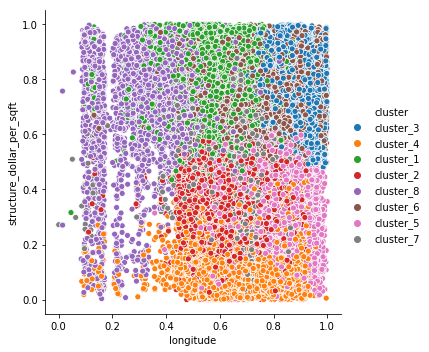

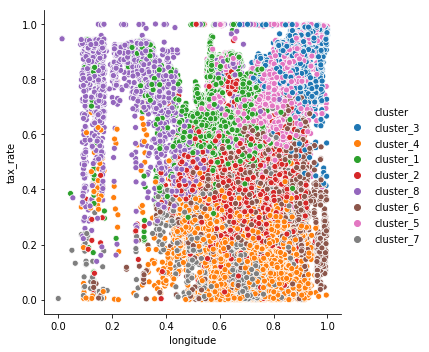

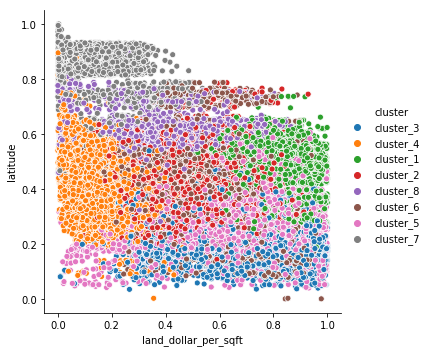

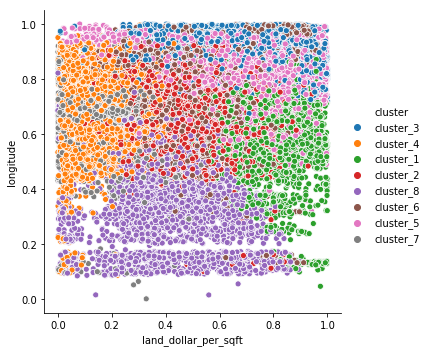

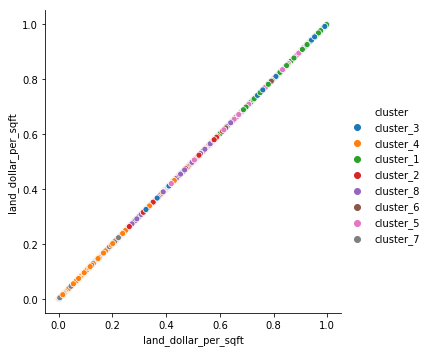

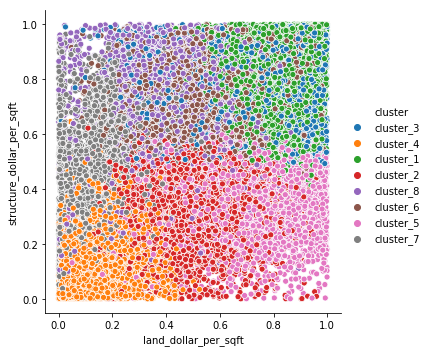

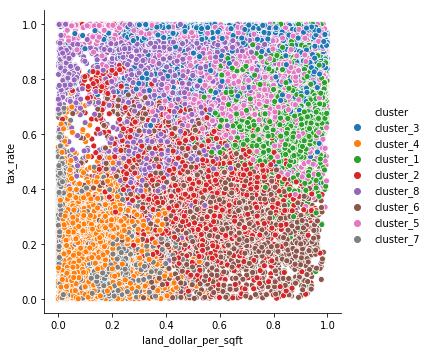

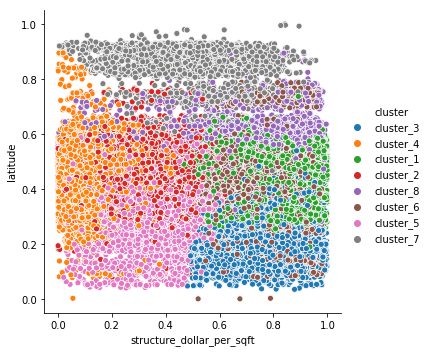

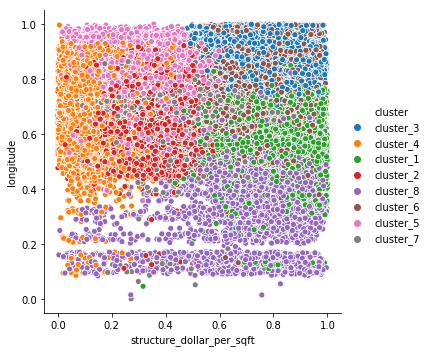

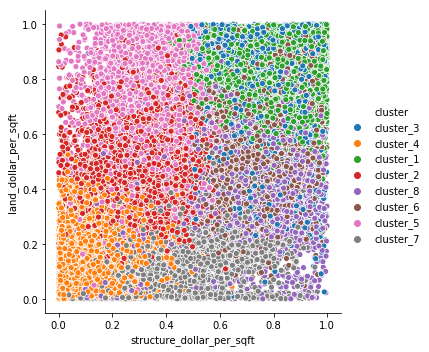

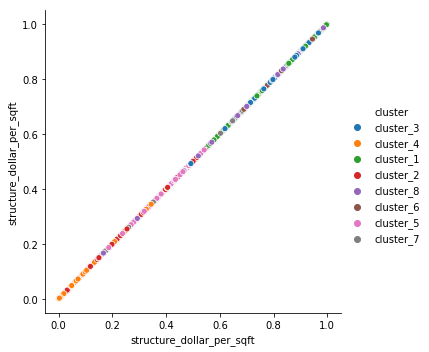

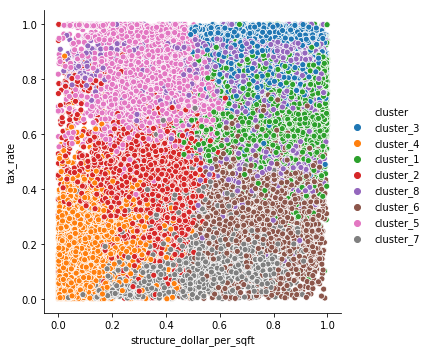

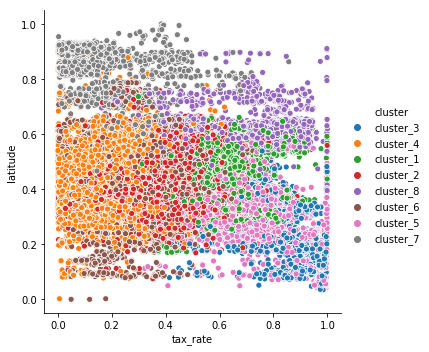

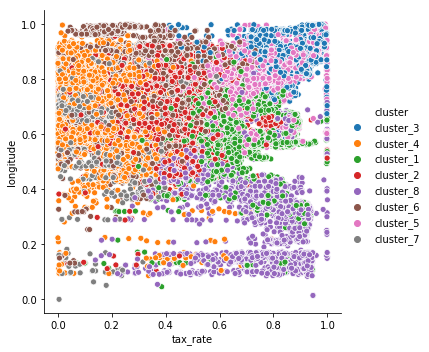

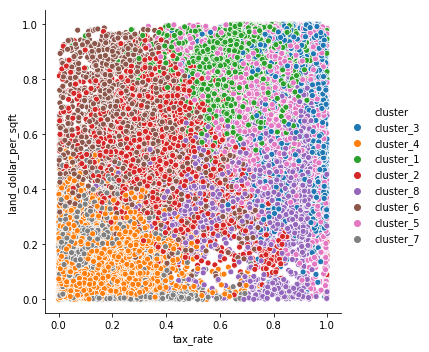

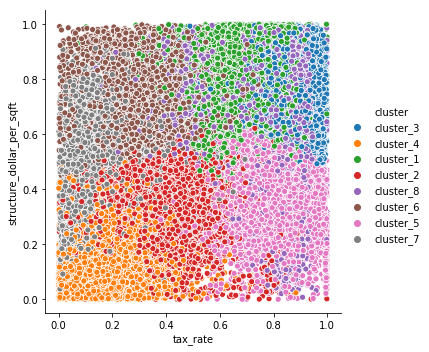

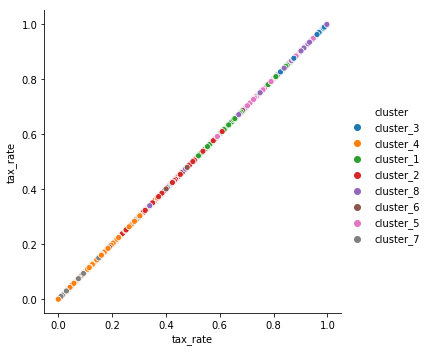

In [126]:
train['cluster'] = kmeans1.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')
for i in range(0,len(cluster1_cols)):
    for j in range(0, len(cluster1_cols)):
        sns.relplot(data=train, x=cluster1_cols[i], y=cluster1_cols[j], hue='cluster')

In [431]:
train.cluster_loc.value_counts()

4    6222
2    5157
1    5088
3    4699
5    4485
0    4079
7    2902
6    2683
Name: cluster_loc, dtype: int64

In [432]:
test.cluster_loc.value_counts()

4    2680
2    2223
1    2206
3    1960
5    1908
0    1736
7    1242
6    1180
Name: cluster_loc, dtype: int64

##### Clustering 2: size fields and age

In [433]:
cluster2_cols = ['lotsizesquarefeet', 'living_area_sqft', 'bedbath_index','age']

(     k          sse  change_in_sse
 0    1  9787.188183            NaN
 1    2  5571.277955   -4215.910227
 2    3  4392.234775   -1179.043180
 3    4  3446.286303    -945.948473
 4    5  3078.573995    -367.712308
 5    6  2813.976725    -264.597270
 6    7  2521.065941    -292.910784
 7    8  2374.942496    -146.123445
 8    9  2235.382567    -139.559929
 9   10  2114.210558    -121.172009
 10  11  2029.607773     -84.602785
 11  12  1919.920328    -109.687445,
 Text(0.5, 1.0, 'The Elbow Method to find the optimal k'))

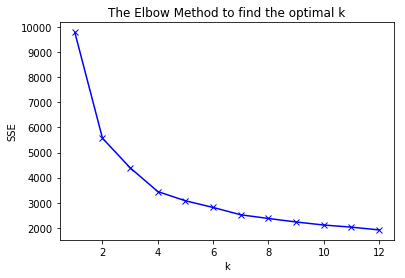

In [272]:
select_k(cluster_df = train[cluster2_cols], ks = range(1,13))

Compare 5 vs. 7 clusters

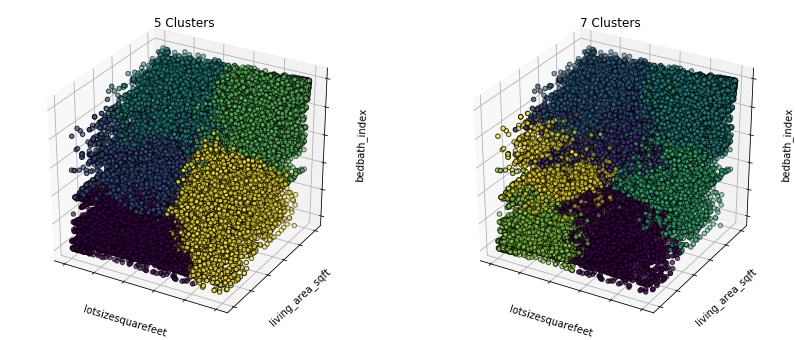

In [273]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='living_area_sqft', z_column='bedbath_index',
                k1=5, k2=7)

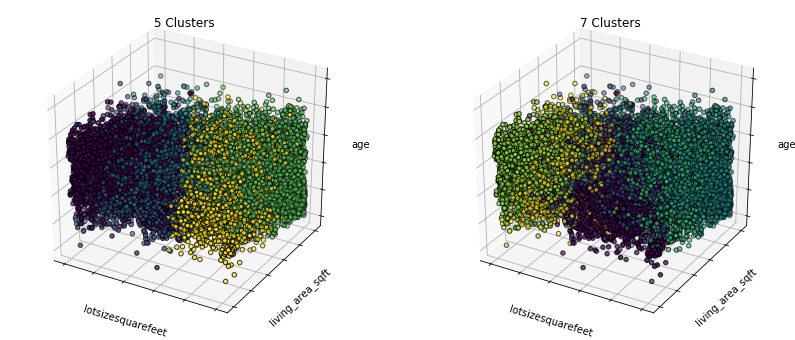

In [274]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='living_area_sqft', z_column='age',
                k1=5, k2=7)

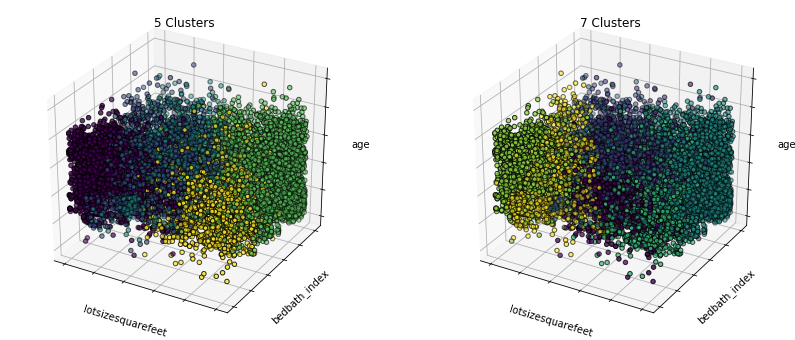

In [275]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='lotsizesquarefeet', y_column='bedbath_index', z_column='age',
                k1=5, k2=7)

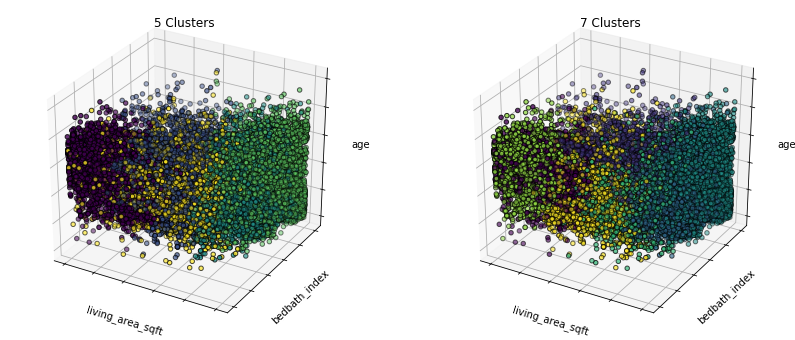

In [276]:
compare_clusters(cluster_df=train[cluster2_cols],
                x_column='living_area_sqft', y_column='bedbath_index', z_column='age',
                k1=5, k2=7)

I'm going to go with 7 clusters.

In [434]:
train, test, kmeans2 = create_k_clusters(train, test, cluster_feature_id = 2, cluster_cols = cluster2_cols, k=7)

In [435]:
train.rename(index=str, columns={'cluster2_id': 'cluster_home'}, inplace=True)
test.rename(index=str, columns={'cluster2_id': 'cluster_home'}, inplace=True)

In [ ]:
train['cluster'] = kmeans2.labels_
train.cluster = 'cluster_' + (train.cluster + 1).astype('str')

for i in range(0,len(cluster2_cols)):
    for j in range(0, len(cluster2_cols)):
        sns.relplot(data=train, x=cluster2_cols[i], y=cluster2_cols[j], hue='cluster')

### Feature Selection

#### Which variables and clusters give information about logerror?

First, I need to confirm that 'logerror' is normally distributed, to determine if I can run t-tests to test the differences in means across different clusters. 

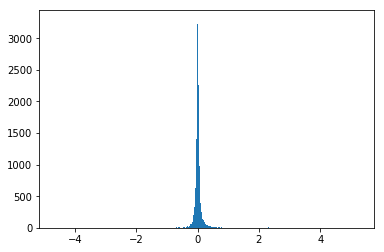

In [436]:
plt.hist(train.logerror, bins=1000)
plt.show()

Looks good!

**Test:** Home driven clusters

First, let's look at the mean log error by cluster id. We will do this for both the train and test as more of a data quality check...to confirm that our cluster id's are showing similar results in both samples. 

In [437]:
print(pd.DataFrame(train.groupby(['cluster_home'])['logerror'].mean().reset_index()))
print(pd.DataFrame(test.groupby(['cluster_home'])['logerror'].mean().reset_index()))

   cluster_home  logerror
0             0  0.027344
1             1  0.017615
2             2  0.013591
3             3  0.022158
4             4  0.012141
5             5  0.018840
6             6  0.011171
   cluster_home  logerror
0             0  0.024682
1             1  0.013843
2             2  0.015311
3             3  0.025138
4             4  0.011959
5             5  0.020689
6             6  0.015416


Test the different in the mean logerror for each cluster vs all others. When the p-value is < .05 then we keep the cluster id, else we replace the cluster id with -1. 

In [438]:
import scipy as sp
import numpy as np

less_significant_clusters = []

for i in range(0,max(train.cluster_home)+1):
    stat, pval = sp.stats.ttest_ind(
        train[train.cluster_home == i].logerror.dropna(),
        train[train.cluster_home != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]

In [439]:
train.cluster_home = train.cluster_home.replace(less_significant_clusters, -1)
test.cluster_home = test.cluster_home.replace(less_significant_clusters, -1)

In [440]:
test.cluster_home.value_counts()

-1    7844
 0    2931
 4    2182
 6    2178
Name: cluster_home, dtype: int64

In [441]:
train.cluster_home.value_counts()

-1    18419
 0     6861
 4     5141
 6     4894
Name: cluster_home, dtype: int64

**Test:** Location driven clusters

In [442]:
pd.DataFrame(train.groupby(['cluster_loc'])['logerror'].mean().reset_index())

cluster_loc  logerror
0            0  0.019741
1            1  0.024139
2            2  0.015539
3            3  0.014164
4            4  0.024066
5            5  0.005056
6            6  0.013978
7            7  0.025255

In [443]:
less_significant_clusters = []

for i in range(0,max(train.cluster_loc)+1):
    stat, pval = sp.stats.ttest_ind(
        train[train.cluster_loc == i].logerror.dropna(),
        train[train.cluster_loc != i].logerror.dropna())
    if pval > .05:
        less_significant_clusters = less_significant_clusters + [i]

In [444]:
less_significant_clusters

[0, 2, 3, 6]

In [445]:
train.cluster_loc = train.cluster_loc.replace(less_significant_clusters, -1)
test.cluster_loc = test.cluster_loc.replace(less_significant_clusters, -1)

**Test:** is_taxdelinquent

In [446]:
pd.DataFrame(train.groupby(['is_taxdelinquent'])['logerror'].mean().reset_index())

is_taxdelinquent  logerror
0               0.0  0.017649
1               1.0  0.024859

In [447]:
stats, pval = sp.stats.ttest_ind(
    train[train.is_taxdelinquent == 0].logerror.dropna(),
    train[train.is_taxdelinquent == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['is_taxdelinquent'], inplace=True)
    test.drop(columns=['is_taxdelinquent'], inplace=True)

**Data Validation**

In [448]:
print(pval)
# if pval < 0.05 then the column should still exist: 
'is_taxdelinquent' in train.columns

0.14293437575630705


False

**Results:** is_taxdelinquent was correctly left as feature. 

_________________________

**Test:** has_pool

In [449]:
pd.DataFrame(train.groupby(['has_pool'])['logerror'].mean().reset_index())

has_pool  logerror
0       0.0  0.018928
1       1.0  0.014434

In [450]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_pool == 0].logerror.dropna(),
    train[train.has_pool == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_pool'], inplace=True)
    test.drop(columns=['has_pool'], inplace=True)

**Data Validation**

In [451]:
print(pval)
# verify column exists if pval < 0.05, and not if greater
'has_pool' in train.columns

0.05045298726648017


False

**Results:** has_pool was correctly left as feature

____________________________ 

**Test:** has_fireplace

In [452]:
pd.DataFrame(train.groupby(['has_fireplace'])['logerror'].mean().reset_index())

has_fireplace  logerror
0            0.0  0.018381
1            1.0  0.015174

In [453]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_fireplace == 0].logerror.dropna(),
    train[train.has_fireplace == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_fireplace'], inplace=True)
    test.drop(columns=['has_fireplace'], inplace=True)

**Data Validation**

In [454]:
print(pval)
# verify column exists if pval < 0.05, and not if greater
'has_fireplace' in train.columns

0.24306621792981484


False

**Results:** has_fireplace was correctly removed
_______________________

**Test:** has_garage

In [455]:
pd.DataFrame(train.groupby(['has_garage'])['logerror'].mean().reset_index())

has_garage  logerror
0         0.0  0.015200
1         1.0  0.023103

In [456]:
stats, pval = sp.stats.ttest_ind(
    train[train.has_garage == 0].logerror.dropna(),
    train[train.has_garage == 1].logerror.dropna())

if pval > .05:
    train.drop(columns=['has_garage'], inplace=True)
    test.drop(columns=['has_garage'], inplace=True)

**Data Validation**

In [457]:
print(pval)

# verify column exists if pval < 0.05, and not if greater
'has_garage' in train.columns


8.187365931604453e-05


True

**Results:** has_garage was correctly left as a feature

_______________________

**Clean up remaining features**

In [458]:
train.head()

regionidcity regionidcounty regionidzip  logerror  has_garage  \
35603        54722           3101       96159  0.047959         0.0   
40112        12447           3101       96040  0.059098         0.0   
55783         5534           3101       97318  0.018814         0.0   
38899        14634           3101       96173 -0.038888         0.0   
70925        24435           3101       96270 -0.010825         0.0   

       lotsizesquarefeet  structure_dollar_per_sqft  land_dollar_per_sqft  \
35603           0.373373                   0.848823              0.764605   
40112           0.249010                   0.198739              0.180339   
55783           0.425134                   0.302227              0.047132   
38899           0.379508                   0.487901              0.532410   
70925           0.615330                   0.026143              0.146550   

       living_area_sqft  tax_rate  bedbath_index  latitude  longitude  \
35603          0.849994  0.787351       0.579580  0.325910   0.604882   
40112          0.002002  0.099989       0.058559  0.394577   0.638185   
55783          0.148148  0.038760       0.381381  0.909890   0.709966   
38899          0.304304  0.385289       0.058559  0.418562   0.757289   
70925          0.282282  0.048695       0.675676  0.546393   0.810707   

            age  cluster_loc  cluster_home  
35603  0.286765            5            -1  
40112  0.676471            4             4  
55783  0.316176           -1            -1  
38899  0.463235            1             4  
70925  0.382353            4            -1

In [487]:
cols_to_remove = ['tax_rate','regionidcity','regionidzip']
non_cluster_features = ['lotsizesquarefeet', 'structure_dollar_per_sqft', 'land_dollar_per_sqft',
                        'living_area_sqft', 'bedbath_index', 'latitude', 'longitude', 'age']
train_no_clusters = train[non_cluster_features+['regionidcounty','logerror']]
test_no_clusters = test[non_cluster_features+['regionidcounty','logerror']]

In [488]:
cols_to_remove = cols_to_remove + non_cluster_features
train_clusters = train.drop(columns=cols_to_remove)
test_clusters = test.drop(columns=cols_to_remove)

In [489]:
train_no_clusters.head()

lotsizesquarefeet  structure_dollar_per_sqft  land_dollar_per_sqft  \
35603           0.373373                   0.848823              0.764605   
40112           0.249010                   0.198739              0.180339   
55783           0.425134                   0.302227              0.047132   
38899           0.379508                   0.487901              0.532410   
70925           0.615330                   0.026143              0.146550   

       living_area_sqft  bedbath_index  latitude  longitude       age  \
35603          0.849994       0.579580  0.325910   0.604882  0.286765   
40112          0.002002       0.058559  0.394577   0.638185  0.676471   
55783          0.148148       0.381381  0.909890   0.709966  0.316176   
38899          0.304304       0.058559  0.418562   0.757289  0.463235   
70925          0.282282       0.675676  0.546393   0.810707  0.382353   

      regionidcounty  logerror  
35603           3101  0.047959  
40112           3101  0.059098  
55783           3101  0.018814  
38899           3101 -0.038888  
70925           3101 -0.010825

In [490]:
train_clusters.head()

regionidcounty  logerror  has_garage  cluster_loc  cluster_home
35603           3101  0.047959         0.0            5            -1
40112           3101  0.059098         0.0            4             4
55783           3101  0.018814         0.0           -1            -1
38899           3101 -0.038888         0.0            1             4
70925           3101 -0.010825         0.0            4            -1

### Encode

Which columns are of numeric format but represent classes or categories?
fips
rawcensustractandblock
regionidcity
regionidcounty
regionidzip


In [491]:
def encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, int_encoder, ohe

def one_hot_encode(train, test, col_name):
  
    encoded_values = sorted(list(train[col_name].unique()))
    columns = [col_name + '_' + str(val) for val in encoded_values]

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)
    
    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=columns, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                               columns=columns, index=test.index)
    test = test.join(test_encoded)

    return train, test, ohe

In [492]:
train_clusters, test_clusters, ohe_loc = one_hot_encode(train_clusters, test_clusters, 'cluster_loc')
train_clusters, test_clusters, ohe_home = one_hot_encode(train_clusters, test_clusters, 'cluster_home')

Build 3 models, 1 for each county
Try with clusters and then try with original features

In [493]:
train_clusters.regionidcounty.value_counts()

3101    22863
1286     9450
2061     3002
Name: regionidcounty, dtype: int64

Separate the clusters dataframes by county

In [494]:
train_3101_c = train_clusters[train_clusters.regionidcounty=='3101']
test_3101_c = test_clusters[test_clusters.regionidcounty=='3101']

train_1286_c = train_clusters[train_clusters.regionidcounty=='1286']
test_1286_c = test_clusters[test_clusters.regionidcounty=='1286']

train_2061_c = train_clusters[train_clusters.regionidcounty=='2061']
test_2061_c = test_clusters[test_clusters.regionidcounty=='2061']

Separate the non-clusters dataframes by county

In [495]:
train_3101_nc = train_no_clusters[train_no_clusters.regionidcounty=='3101']
test_3101_nc = test_no_clusters[test_no_clusters.regionidcounty=='3101']

train_1286_nc = train_no_clusters[train_no_clusters.regionidcounty=='1286']
test_1286_nc = test_no_clusters[test_no_clusters.regionidcounty=='1286']

train_2061_nc = train_no_clusters[train_no_clusters.regionidcounty=='2061']
test_2061_nc = test_no_clusters[test_no_clusters.regionidcounty=='2061']

Now that we have encoded and split by county, we can remove some other columns to have our final X with features.
We only need a y_train and y_test for each county, not separated by the features, obviously. 

X dataframes for the cluster features:

In [506]:
cols_to_drop = ['cluster_loc', 'cluster_home', 'cluster_loc_-1', 'cluster_home_-1', 'logerror', 'regionidcounty']

X_train_3101_c = train_3101_c.drop(columns=cols_to_drop)
X_test_3101_c = test_3101_c.drop(columns=cols_to_drop)

X_train_1286_c = train_1286_c.drop(columns=cols_to_drop)
X_test_1286_c = test_1286_c.drop(columns=cols_to_drop)

X_train_2061_c = train_2061_c.drop(columns=cols_to_drop)
X_test_2061_c = test_2061_c.drop(columns=cols_to_drop)

X dataframes for the non-cluster features

In [507]:
cols_to_drop = ['logerror', 'regionidcounty']

X_train_3101_nc = train_3101_nc.drop(columns=cols_to_drop)
X_test_3101_nc = test_3101_nc.drop(columns=cols_to_drop)

X_train_1286_nc = train_1286_nc.drop(columns=cols_to_drop)
X_test_1286_nc = test_1286_nc.drop(columns=cols_to_drop)

X_train_2061_nc = train_2061_nc.drop(columns=cols_to_drop)
X_test_2061_nc = test_2061_nc.drop(columns=cols_to_drop)

y dataframes

In [508]:
y_train_3101 = train_3101_c[['logerror']]
y_test_3101 = test_3101_c[['logerror']]

y_train_1286 = train_1286_c[['logerror']]
y_test_1286 = test_1286_c[['logerror']]

y_train_2061 = train_2061_c[['logerror']]
y_test_2061 = test_2061_c[['logerror']]

## Model

In [518]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor

### county: 3101

#### Baseline

In [519]:
se = y_train_3101.logerror * y_train_3101.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.015538044100605487

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [520]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_c)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.015414150593934408


##### Support Gradient Descent Regressor from sklearn.linear_model

In [521]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015414201616581974

##### Lasso with Cross Validation from sklearn.linear_model

In [522]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015415275519598787

##### Decision Tree Regressor from sklearn.tree

In [523]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015378272875637523

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [525]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_nc)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.015366049878065368


##### Support Gradient Descent Regressor from sklearn.linear_model

In [526]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015367720713032917

##### Lasso with Cross Validation from sklearn.linear_model

In [527]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015367701981182098

##### Decision Tree Regressor from sklearn.tree

In [528]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

7.661575016028199e-10

WOW!!!

### county: 3101

#### Baseline

In [519]:
se = y_train_3101.logerror * y_train_3101.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.015538044100605487

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [520]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_c)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.015414150593934408


##### Support Gradient Descent Regressor from sklearn.linear_model

In [521]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015414201616581974

##### Lasso with Cross Validation from sklearn.linear_model

In [522]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015415275519598787

##### Decision Tree Regressor from sklearn.tree

In [523]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_3101_c, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_c)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015378272875637523

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [525]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = regr.predict(X_train_3101_nc)
print(mean_squared_error(y_train_3101, y_pred_3101)**1/2)

0.015366049878065368


##### Support Gradient Descent Regressor from sklearn.linear_model

In [526]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = sgd.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015367720713032917

##### Lasso with Cross Validation from sklearn.linear_model

In [527]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = lasso.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

0.015367701981182098

##### Decision Tree Regressor from sklearn.tree

In [528]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_3101_nc, y_train_3101)
y_pred_3101 = dt.predict(X_train_3101_nc)
mean_squared_error(y_train_3101, y_pred_3101)**1/2

7.661575016028199e-10

WOW!!!

### county: 1286

#### Baseline

In [529]:
se = y_train_1286.logerror * y_train_1286.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.01937882498035345

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [530]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = regr.predict(X_train_1286_c)
print(mean_squared_error(y_train_1286, y_pred_1286)**1/2)

0.01902102493575427


##### Support Gradient Descent Regressor from sklearn.linear_model

In [531]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = sgd.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019021218828580575

##### Lasso with Cross Validation from sklearn.linear_model

In [532]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = lasso.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.019031766729031813

##### Decision Tree Regressor from sklearn.tree

In [533]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_1286_c, y_train_1286)
y_pred_1286 = dt.predict(X_train_1286_c)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.018992927976933683

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [534]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = regr.predict(X_train_1286_nc)
print(mean_squared_error(y_train_1286, y_pred_1286)**1/2)

0.0189875821406002


##### Support Gradient Descent Regressor from sklearn.linear_model

In [535]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_1286_nc, y_train_1286)
y_pred_3101 = sgd.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.0189875821406002

##### Lasso with Cross Validation from sklearn.linear_model

In [536]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = lasso.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

0.01899553042532808

##### Decision Tree Regressor from sklearn.tree

In [537]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_1286_nc, y_train_1286)
y_pred_1286 = dt.predict(X_train_1286_nc)
mean_squared_error(y_train_1286, y_pred_1286)**1/2

1.1352117171893855e-09

WOW again!

### county: 2061

#### Baseline

In [538]:
se = y_train_2061.logerror * y_train_2061.logerror
mse = se.mean()
rmse = mse**1/2
rmse

0.011707585358987844

#### Clustering Features

##### Linear Support Vector Regressor from sklearn.svm

In [539]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = regr.predict(X_train_2061_c)
print(mean_squared_error(y_train_2061, y_pred_2061)**1/2)

0.011559555536774924


##### Support Gradient Descent Regressor from sklearn.linear_model

In [540]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = sgd.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.011559625345744553

##### Lasso with Cross Validation from sklearn.linear_model

In [541]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = lasso.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.011575762920189869

##### Decision Tree Regressor from sklearn.tree

In [542]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_2061_c, y_train_2061)
y_pred_2061 = dt.predict(X_train_2061_c)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.011350602573273885

#### non-clustering features

##### Linear Support Vector Regressor from sklearn.svm

In [544]:
regr = LinearSVR(random_state=123, tol=1e-5, loss='squared_epsilon_insensitive', fit_intercept=False, dual=False)
regr.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = regr.predict(X_train_2061_nc)
print(mean_squared_error(y_train_2061, y_pred_2061)**1/2)

0.011562579405687034


##### Support Gradient Descent Regressor from sklearn.linear_model

In [545]:
sgd = SGDRegressor(fit_intercept=False, max_iter=1000, random_state=123)
sgd.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = sgd.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.01156278156625619

##### Lasso with Cross Validation from sklearn.linear_model

In [546]:
lasso = LassoCV(fit_intercept=False)
lasso.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = lasso.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

0.011604737940999886

##### Decision Tree Regressor from sklearn.tree

In [547]:
dt = DecisionTreeRegressor(random_state=123)
dt.fit(X_train_2061_nc, y_train_2061)
y_pred_2061 = dt.predict(X_train_2061_nc)
mean_squared_error(y_train_2061, y_pred_2061)**1/2

1.0699005570669292e-09